In [1]:
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/home/cuakevinlex/Documents/DL_HW3': ['LSTM', 'shakespeare_valid.txt', '.ipynb_checkpoints', 'shakespeare_train.txt', 'RNN', 'dl_hw3.ipynb']


In [2]:
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
from torch.autograd import Variable
import math
import matplotlib.pyplot as plt
import io


In [3]:
# Hyperparameters
BATCH_SIZE=100
input_size = 32
hidden_size = 256
num_layers = 2
sequence_length = 50
learning_rate = 0.00001
batch_size = 64
num_epochs = 10

In [4]:
data_URL = "shakespeare_train.txt"
with io.open(data_URL, 'r', encoding='utf-8') as f:
    text = f.read()
# Characters' Collection
char = set(text)
# construct character dictionary
char_to_int = {c : i for i , c in enumerate( char )}
int_to_char = dict(enumerate(char))
# Encode data , shape = [ number of c h a r a ct e r s ]

num_classes = len(int_to_char)

dtype = torch.FloatTensor
training_data = np.array([char_to_int[c] for c in text], dtype=np.int32)

In [5]:
data_URL = "shakespeare_valid.txt"
with io.open(data_URL, 'r', encoding='utf-8') as f:
    text = f.read()
# Characters' Collection
char_valid = set(text)

val_data = np.array([char_to_int[c] for c in text], dtype=np.int32)

In [6]:
print(char)

{"'", 'x', '.', 'n', 'L', 'Y', 'V', 'm', 'y', '!', 'p', 'X', 'c', 'l', 'g', 'C', 'M', 'r', 'U', 'D', 's', 'w', 'R', 'h', '-', 'K', 'I', 'Q', '[', ' ', 'G', 'F', 'i', '&', 'z', 'e', 'S', 'j', 't', 'B', 'f', ':', 'q', ',', 'O', 'T', 'v', 'Z', '$', 'o', 'k', ']', 'a', 'N', 'J', 'b', ';', 'W', 'P', 'd', 'u', 'A', '?', '\n', 'H', '3', 'E'}


In [7]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot


In [8]:
text = ""
for i in training_data:
    text+= str(int_to_char[i])
#print(text)

In [9]:
text = ""
for i in val_data:
    text+= str(int_to_char[i])
print(text)

DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the sweet sound,
That breathes upon a bank of violets,
Stealing and giving odour! Enough; no more:
'Tis not so sweet now as it was before.
O spirit of love! how quick and fresh art thou,
That, notwithstanding thy capacity
Receiveth as the sea, nought enters there,
Of what validity and pitch soe'er,
But falls into abatement and low price,
Even in a minute: so full of shapes is fancy
That it alone is high fantastical.

CURIO:
Will you go hunt, my lord?

DUKE ORSINO:
What, Curio?

CURIO:
The hart.

DUKE ORSINO:
Why, so I do, the noblest that I have:
O, when mine eyes did see Olivia first,
Methought she purged the air of pestilence!
That instant was I turn'd into a hart;
And my desires, like fell and cruel hounds,
E'er since pursue me.
How now! what news from her?

VALENTINE:
So please my lord, I

In [10]:
def build_sequences(text, window):
    x = list()
    y = list()
    
    for i in range(len(text)):
        try:
            # Get window of chars from text then, transform it into its idx representation
            sequence = text[i:i+window].tolist()
            
            # Get word target
            target = text[i+window]
            
            # Save sequences and targets
            x.append(sequence)
            y.append(target)
            
        except Exception as e: 
            pass
        
    x = np.array(x)
    y = np.array(y)
    
    return x, y

In [11]:
# Creates data based on text array and sets x as the first sequence count target is char right after
x, y = build_sequences(training_data, sequence_length)
x_val, y_val = build_sequences(val_data, sequence_length)

In [12]:
print(x)
print(y)

[[31 32 17 ... 35 52 17]
 [32 17 20 ... 52 17 29]
 [17 20 38 ... 17 29  7]
 ...
 [49  3 59 ... 40 52 13]
 [ 3 59 49 ... 52 13 13]
 [59 49  3 ... 13 13  9]]
[29  7 35 ... 13  9 63]


In [13]:
x = Variable(torch.from_numpy(x))
y = Variable(torch.from_numpy(y))
x_val = Variable(torch.from_numpy(x_val))
y_val = Variable(torch.from_numpy(y_val))

In [14]:
training_data = torch.utils.data.TensorDataset(x,y.long())
val_data = torch.utils.data.TensorDataset(x_val, y_val.long())


train_count = len(training_data)
val_count = len(val_data)

# training_data, val_data = torch.utils.data.random_split(training_data, [int(train_count*.9), train_count - int(train_count*.9)])
train_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=True)

#used for generating data as seed
sequences = []
for batch_idx, (data, targets) in enumerate(train_loader):
    for seq in data:
        sequences.append(seq.numpy())
sequences = np.array(sequences)

In [15]:
# storing gpu availability on boolean var
is_cuda = torch.cuda.is_available()

# checking for GPU
if is_cuda:
    device = torch.device("cuda")
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [16]:
class RNN(nn.Module):
    def __init__(self, sequence_length, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.sequence_length = sequence_length
        
        self.rnn = nn.RNN(num_classes, hidden_size, num_layers, batch_first=True)
        self.fully_connected = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, x):
        
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate RNN
        x, _ = self.rnn(x, h0)
        x = x.reshape(x.shape[0], -1)

        # Decode the hidden state of the last time step
        # print(out.shape)
        x = self.fully_connected(x)
        
        return x

In [17]:
# Initialize network
rnn = RNN(sequence_length, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)


In [18]:
learning_curve = []
training_acc = []
val_acc = []
# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        
        # Get data to cuda if possible
        data = one_hot_encode(data, num_classes)
        data = torch.from_numpy(data).to(device=device)
        targets = targets.to(device=device)
        
        # forward
        scores = rnn(data)
        loss = criterion(scores, targets)
        cel = loss.item()
        
        # accuracy and loss
        predicted = torch.max(scores.data, 1)[1] 
        correct = (predicted == targets).sum()
        accuracy = correct/len(predicted)*100
        training_acc.append(accuracy.item())
        learning_curve.append(cel)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        
        
        # validation computation
        x_val, y_val = next(iter(val_loader))
        x_val = one_hot_encode(x_val,num_classes)
        x_val = torch.from_numpy(x_val).to(device=device)
        y_val = y_val.to(device=device)
        score_val = rnn(x_val)
        val_loss = criterion(score_val, y_val)
        val_cel = val_loss.item()
        
        # val acciracu
        predicted_val = torch.max(score_val.data, 1)[1] 
        correct_val = (predicted_val == y_val).sum()
        accuracy_val = correct_val/len(predicted_val)*100
        val_acc.append(accuracy_val.item())
        
        # gradient descent or adam step
        optimizer.step()
        if batch_idx % 250 == 0: 
            currently_run = batch_idx*len(data)
            data_total = len(train_loader.dataset)
            percent_of_data_run = 100.*batch_idx / len(train_loader)
            print('Epoch: {}[{}/{} ({:.0f}%)]\t Error:{:.2f}\t Accuracy:{:.2f}\t Val Error:{:.2f}'.format(
              epoch, currently_run, data_total, percent_of_data_run, cel, accuracy, val_cel))
    PATH = 'rnn_' + str(epoch) + 'epochs.pt'
    torch.save(rnn.state_dict(), PATH)

Epoch: 0[0/4351262 (0%)]	 Error:4.21	 Accuracy:3.00	 Val Error:4.21
Epoch: 0[25000/4351262 (1%)]	 Error:3.48	 Accuracy:10.00	 Val Error:3.38
Epoch: 0[50000/4351262 (1%)]	 Error:3.13	 Accuracy:23.00	 Val Error:3.35
Epoch: 0[75000/4351262 (2%)]	 Error:3.42	 Accuracy:12.00	 Val Error:3.35
Epoch: 0[100000/4351262 (2%)]	 Error:3.41	 Accuracy:13.00	 Val Error:3.24
Epoch: 0[125000/4351262 (3%)]	 Error:3.47	 Accuracy:7.00	 Val Error:3.24
Epoch: 0[150000/4351262 (3%)]	 Error:3.59	 Accuracy:12.00	 Val Error:3.33
Epoch: 0[175000/4351262 (4%)]	 Error:3.24	 Accuracy:11.00	 Val Error:3.38
Epoch: 0[200000/4351262 (5%)]	 Error:3.27	 Accuracy:11.00	 Val Error:3.40
Epoch: 0[225000/4351262 (5%)]	 Error:3.17	 Accuracy:19.00	 Val Error:3.07
Epoch: 0[250000/4351262 (6%)]	 Error:3.28	 Accuracy:13.00	 Val Error:3.18
Epoch: 0[275000/4351262 (6%)]	 Error:3.09	 Accuracy:18.00	 Val Error:3.13
Epoch: 0[300000/4351262 (7%)]	 Error:3.28	 Accuracy:13.00	 Val Error:3.20
Epoch: 0[325000/4351262 (7%)]	 Error:3.12	 Accur

Epoch: 0[2725000/4351262 (63%)]	 Error:2.56	 Accuracy:24.00	 Val Error:2.46
Epoch: 0[2750000/4351262 (63%)]	 Error:2.38	 Accuracy:33.00	 Val Error:2.40
Epoch: 0[2775000/4351262 (64%)]	 Error:2.40	 Accuracy:37.00	 Val Error:2.44
Epoch: 0[2800000/4351262 (64%)]	 Error:2.48	 Accuracy:26.00	 Val Error:2.27
Epoch: 0[2825000/4351262 (65%)]	 Error:2.38	 Accuracy:35.00	 Val Error:2.37
Epoch: 0[2850000/4351262 (65%)]	 Error:2.33	 Accuracy:31.00	 Val Error:2.54
Epoch: 0[2875000/4351262 (66%)]	 Error:2.58	 Accuracy:37.00	 Val Error:2.27
Epoch: 0[2900000/4351262 (67%)]	 Error:2.34	 Accuracy:33.00	 Val Error:2.46
Epoch: 0[2925000/4351262 (67%)]	 Error:2.35	 Accuracy:30.00	 Val Error:2.22
Epoch: 0[2950000/4351262 (68%)]	 Error:2.35	 Accuracy:35.00	 Val Error:2.63
Epoch: 0[2975000/4351262 (68%)]	 Error:2.43	 Accuracy:27.00	 Val Error:2.45
Epoch: 0[3000000/4351262 (69%)]	 Error:2.45	 Accuracy:31.00	 Val Error:2.14
Epoch: 0[3025000/4351262 (70%)]	 Error:2.70	 Accuracy:23.00	 Val Error:2.46
Epoch: 0[305

Epoch: 1[1075000/4351262 (25%)]	 Error:2.20	 Accuracy:41.00	 Val Error:2.33
Epoch: 1[1100000/4351262 (25%)]	 Error:2.26	 Accuracy:41.00	 Val Error:2.67
Epoch: 1[1125000/4351262 (26%)]	 Error:2.54	 Accuracy:28.00	 Val Error:2.23
Epoch: 1[1150000/4351262 (26%)]	 Error:2.24	 Accuracy:35.00	 Val Error:2.45
Epoch: 1[1175000/4351262 (27%)]	 Error:2.12	 Accuracy:42.00	 Val Error:2.33
Epoch: 1[1200000/4351262 (28%)]	 Error:2.09	 Accuracy:40.00	 Val Error:2.30
Epoch: 1[1225000/4351262 (28%)]	 Error:2.23	 Accuracy:35.00	 Val Error:2.14
Epoch: 1[1250000/4351262 (29%)]	 Error:2.27	 Accuracy:36.00	 Val Error:2.31
Epoch: 1[1275000/4351262 (29%)]	 Error:1.96	 Accuracy:41.00	 Val Error:2.58
Epoch: 1[1300000/4351262 (30%)]	 Error:2.19	 Accuracy:39.00	 Val Error:2.30
Epoch: 1[1325000/4351262 (30%)]	 Error:2.24	 Accuracy:39.00	 Val Error:2.24
Epoch: 1[1350000/4351262 (31%)]	 Error:2.26	 Accuracy:35.00	 Val Error:2.38
Epoch: 1[1375000/4351262 (32%)]	 Error:2.31	 Accuracy:32.00	 Val Error:2.32
Epoch: 1[140

Epoch: 1[3775000/4351262 (87%)]	 Error:2.14	 Accuracy:38.00	 Val Error:2.05
Epoch: 1[3800000/4351262 (87%)]	 Error:2.08	 Accuracy:40.00	 Val Error:2.02
Epoch: 1[3825000/4351262 (88%)]	 Error:2.30	 Accuracy:36.00	 Val Error:2.16
Epoch: 1[3850000/4351262 (88%)]	 Error:2.18	 Accuracy:42.00	 Val Error:2.08
Epoch: 1[3875000/4351262 (89%)]	 Error:2.28	 Accuracy:41.00	 Val Error:2.05
Epoch: 1[3900000/4351262 (90%)]	 Error:2.04	 Accuracy:44.00	 Val Error:2.46
Epoch: 1[3925000/4351262 (90%)]	 Error:2.30	 Accuracy:35.00	 Val Error:2.02
Epoch: 1[3950000/4351262 (91%)]	 Error:2.23	 Accuracy:32.00	 Val Error:2.08
Epoch: 1[3975000/4351262 (91%)]	 Error:2.24	 Accuracy:34.00	 Val Error:2.04
Epoch: 1[4000000/4351262 (92%)]	 Error:2.47	 Accuracy:30.00	 Val Error:2.16
Epoch: 1[4025000/4351262 (93%)]	 Error:2.10	 Accuracy:40.00	 Val Error:2.07
Epoch: 1[4050000/4351262 (93%)]	 Error:2.33	 Accuracy:28.00	 Val Error:2.21
Epoch: 1[4075000/4351262 (94%)]	 Error:2.01	 Accuracy:36.00	 Val Error:1.99
Epoch: 1[410

Epoch: 2[2125000/4351262 (49%)]	 Error:2.01	 Accuracy:40.00	 Val Error:2.21
Epoch: 2[2150000/4351262 (49%)]	 Error:1.83	 Accuracy:44.00	 Val Error:2.38
Epoch: 2[2175000/4351262 (50%)]	 Error:2.18	 Accuracy:41.00	 Val Error:2.23
Epoch: 2[2200000/4351262 (51%)]	 Error:2.01	 Accuracy:37.00	 Val Error:2.14
Epoch: 2[2225000/4351262 (51%)]	 Error:1.97	 Accuracy:38.00	 Val Error:2.04
Epoch: 2[2250000/4351262 (52%)]	 Error:2.25	 Accuracy:43.00	 Val Error:2.30
Epoch: 2[2275000/4351262 (52%)]	 Error:2.10	 Accuracy:36.00	 Val Error:2.06
Epoch: 2[2300000/4351262 (53%)]	 Error:2.09	 Accuracy:42.00	 Val Error:2.04
Epoch: 2[2325000/4351262 (53%)]	 Error:2.10	 Accuracy:40.00	 Val Error:2.24
Epoch: 2[2350000/4351262 (54%)]	 Error:2.31	 Accuracy:30.00	 Val Error:2.13
Epoch: 2[2375000/4351262 (55%)]	 Error:2.32	 Accuracy:34.00	 Val Error:1.94
Epoch: 2[2400000/4351262 (55%)]	 Error:2.10	 Accuracy:41.00	 Val Error:2.29
Epoch: 2[2425000/4351262 (56%)]	 Error:1.86	 Accuracy:47.00	 Val Error:1.93
Epoch: 2[245

Epoch: 3[475000/4351262 (11%)]	 Error:2.27	 Accuracy:34.00	 Val Error:1.91
Epoch: 3[500000/4351262 (11%)]	 Error:2.07	 Accuracy:41.00	 Val Error:2.17
Epoch: 3[525000/4351262 (12%)]	 Error:2.19	 Accuracy:40.00	 Val Error:2.14
Epoch: 3[550000/4351262 (13%)]	 Error:2.06	 Accuracy:43.00	 Val Error:2.04
Epoch: 3[575000/4351262 (13%)]	 Error:2.01	 Accuracy:40.00	 Val Error:2.13
Epoch: 3[600000/4351262 (14%)]	 Error:2.14	 Accuracy:30.00	 Val Error:2.17
Epoch: 3[625000/4351262 (14%)]	 Error:1.87	 Accuracy:49.00	 Val Error:2.00
Epoch: 3[650000/4351262 (15%)]	 Error:2.09	 Accuracy:45.00	 Val Error:2.23
Epoch: 3[675000/4351262 (16%)]	 Error:2.07	 Accuracy:43.00	 Val Error:2.01
Epoch: 3[700000/4351262 (16%)]	 Error:2.07	 Accuracy:46.00	 Val Error:1.98
Epoch: 3[725000/4351262 (17%)]	 Error:1.97	 Accuracy:43.00	 Val Error:2.26
Epoch: 3[750000/4351262 (17%)]	 Error:2.28	 Accuracy:35.00	 Val Error:2.28
Epoch: 3[775000/4351262 (18%)]	 Error:2.01	 Accuracy:42.00	 Val Error:2.25
Epoch: 3[800000/4351262 (

Epoch: 3[3200000/4351262 (74%)]	 Error:1.97	 Accuracy:42.00	 Val Error:2.00
Epoch: 3[3225000/4351262 (74%)]	 Error:2.20	 Accuracy:40.00	 Val Error:1.99
Epoch: 3[3250000/4351262 (75%)]	 Error:2.07	 Accuracy:36.00	 Val Error:2.11
Epoch: 3[3275000/4351262 (75%)]	 Error:2.17	 Accuracy:33.00	 Val Error:2.07
Epoch: 3[3300000/4351262 (76%)]	 Error:2.26	 Accuracy:40.00	 Val Error:2.17
Epoch: 3[3325000/4351262 (76%)]	 Error:2.03	 Accuracy:41.00	 Val Error:1.81
Epoch: 3[3350000/4351262 (77%)]	 Error:2.25	 Accuracy:31.00	 Val Error:1.89
Epoch: 3[3375000/4351262 (78%)]	 Error:2.09	 Accuracy:36.00	 Val Error:2.04
Epoch: 3[3400000/4351262 (78%)]	 Error:2.37	 Accuracy:27.00	 Val Error:1.90
Epoch: 3[3425000/4351262 (79%)]	 Error:2.09	 Accuracy:37.00	 Val Error:1.90
Epoch: 3[3450000/4351262 (79%)]	 Error:2.10	 Accuracy:39.00	 Val Error:2.00
Epoch: 3[3475000/4351262 (80%)]	 Error:1.97	 Accuracy:32.00	 Val Error:1.74
Epoch: 3[3500000/4351262 (80%)]	 Error:2.06	 Accuracy:38.00	 Val Error:1.95
Epoch: 3[352

Epoch: 4[1550000/4351262 (36%)]	 Error:1.98	 Accuracy:50.00	 Val Error:2.00
Epoch: 4[1575000/4351262 (36%)]	 Error:1.91	 Accuracy:46.00	 Val Error:2.18
Epoch: 4[1600000/4351262 (37%)]	 Error:2.00	 Accuracy:36.00	 Val Error:1.90
Epoch: 4[1625000/4351262 (37%)]	 Error:1.86	 Accuracy:46.00	 Val Error:2.23
Epoch: 4[1650000/4351262 (38%)]	 Error:1.85	 Accuracy:42.00	 Val Error:2.27
Epoch: 4[1675000/4351262 (38%)]	 Error:2.04	 Accuracy:44.00	 Val Error:2.31
Epoch: 4[1700000/4351262 (39%)]	 Error:2.08	 Accuracy:43.00	 Val Error:1.91
Epoch: 4[1725000/4351262 (40%)]	 Error:1.79	 Accuracy:53.00	 Val Error:2.05
Epoch: 4[1750000/4351262 (40%)]	 Error:2.01	 Accuracy:42.00	 Val Error:2.18
Epoch: 4[1775000/4351262 (41%)]	 Error:1.98	 Accuracy:36.00	 Val Error:2.31
Epoch: 4[1800000/4351262 (41%)]	 Error:2.33	 Accuracy:35.00	 Val Error:2.07
Epoch: 4[1825000/4351262 (42%)]	 Error:1.73	 Accuracy:45.00	 Val Error:1.97
Epoch: 4[1850000/4351262 (43%)]	 Error:2.25	 Accuracy:38.00	 Val Error:2.35
Epoch: 4[187

Epoch: 4[4250000/4351262 (98%)]	 Error:2.12	 Accuracy:38.00	 Val Error:1.92
Epoch: 4[4275000/4351262 (98%)]	 Error:1.79	 Accuracy:48.00	 Val Error:1.91
Epoch: 4[4300000/4351262 (99%)]	 Error:1.72	 Accuracy:48.00	 Val Error:2.03
Epoch: 4[4325000/4351262 (99%)]	 Error:1.97	 Accuracy:39.00	 Val Error:2.19
Epoch: 4[4350000/4351262 (100%)]	 Error:2.12	 Accuracy:41.00	 Val Error:2.02
Epoch: 5[0/4351262 (0%)]	 Error:2.00	 Accuracy:43.00	 Val Error:2.12
Epoch: 5[25000/4351262 (1%)]	 Error:1.85	 Accuracy:49.00	 Val Error:2.03
Epoch: 5[50000/4351262 (1%)]	 Error:1.92	 Accuracy:43.00	 Val Error:2.11
Epoch: 5[75000/4351262 (2%)]	 Error:1.95	 Accuracy:43.00	 Val Error:1.86
Epoch: 5[100000/4351262 (2%)]	 Error:2.12	 Accuracy:33.00	 Val Error:2.19
Epoch: 5[125000/4351262 (3%)]	 Error:1.72	 Accuracy:46.00	 Val Error:2.08
Epoch: 5[150000/4351262 (3%)]	 Error:2.10	 Accuracy:38.00	 Val Error:2.04
Epoch: 5[175000/4351262 (4%)]	 Error:1.98	 Accuracy:40.00	 Val Error:2.08
Epoch: 5[200000/4351262 (5%)]	 Erro

Epoch: 5[2600000/4351262 (60%)]	 Error:1.71	 Accuracy:40.00	 Val Error:2.03
Epoch: 5[2625000/4351262 (60%)]	 Error:2.05	 Accuracy:40.00	 Val Error:1.93
Epoch: 5[2650000/4351262 (61%)]	 Error:1.87	 Accuracy:44.00	 Val Error:2.05
Epoch: 5[2675000/4351262 (61%)]	 Error:2.00	 Accuracy:36.00	 Val Error:2.19
Epoch: 5[2700000/4351262 (62%)]	 Error:2.01	 Accuracy:45.00	 Val Error:2.00
Epoch: 5[2725000/4351262 (63%)]	 Error:2.06	 Accuracy:40.00	 Val Error:2.14
Epoch: 5[2750000/4351262 (63%)]	 Error:1.80	 Accuracy:47.00	 Val Error:2.10
Epoch: 5[2775000/4351262 (64%)]	 Error:1.86	 Accuracy:47.00	 Val Error:2.24
Epoch: 5[2800000/4351262 (64%)]	 Error:1.96	 Accuracy:42.00	 Val Error:2.12
Epoch: 5[2825000/4351262 (65%)]	 Error:1.76	 Accuracy:50.00	 Val Error:1.96
Epoch: 5[2850000/4351262 (65%)]	 Error:1.75	 Accuracy:49.00	 Val Error:2.10
Epoch: 5[2875000/4351262 (66%)]	 Error:1.76	 Accuracy:53.00	 Val Error:2.19
Epoch: 5[2900000/4351262 (67%)]	 Error:2.00	 Accuracy:42.00	 Val Error:1.70
Epoch: 5[292

Epoch: 6[950000/4351262 (22%)]	 Error:1.89	 Accuracy:46.00	 Val Error:2.05
Epoch: 6[975000/4351262 (22%)]	 Error:1.93	 Accuracy:42.00	 Val Error:1.86
Epoch: 6[1000000/4351262 (23%)]	 Error:1.74	 Accuracy:48.00	 Val Error:1.93
Epoch: 6[1025000/4351262 (24%)]	 Error:1.99	 Accuracy:43.00	 Val Error:2.08
Epoch: 6[1050000/4351262 (24%)]	 Error:2.03	 Accuracy:37.00	 Val Error:1.84
Epoch: 6[1075000/4351262 (25%)]	 Error:1.74	 Accuracy:47.00	 Val Error:2.03
Epoch: 6[1100000/4351262 (25%)]	 Error:1.93	 Accuracy:45.00	 Val Error:1.97
Epoch: 6[1125000/4351262 (26%)]	 Error:1.84	 Accuracy:41.00	 Val Error:1.73
Epoch: 6[1150000/4351262 (26%)]	 Error:2.02	 Accuracy:39.00	 Val Error:1.92
Epoch: 6[1175000/4351262 (27%)]	 Error:1.87	 Accuracy:45.00	 Val Error:1.99
Epoch: 6[1200000/4351262 (28%)]	 Error:1.72	 Accuracy:53.00	 Val Error:2.01
Epoch: 6[1225000/4351262 (28%)]	 Error:1.97	 Accuracy:43.00	 Val Error:2.14
Epoch: 6[1250000/4351262 (29%)]	 Error:1.93	 Accuracy:44.00	 Val Error:1.80
Epoch: 6[12750

Epoch: 6[3650000/4351262 (84%)]	 Error:2.00	 Accuracy:41.00	 Val Error:1.94
Epoch: 6[3675000/4351262 (84%)]	 Error:1.79	 Accuracy:53.00	 Val Error:1.86
Epoch: 6[3700000/4351262 (85%)]	 Error:2.13	 Accuracy:40.00	 Val Error:1.78
Epoch: 6[3725000/4351262 (86%)]	 Error:2.00	 Accuracy:40.00	 Val Error:2.14
Epoch: 6[3750000/4351262 (86%)]	 Error:1.95	 Accuracy:43.00	 Val Error:2.02
Epoch: 6[3775000/4351262 (87%)]	 Error:1.90	 Accuracy:44.00	 Val Error:1.97
Epoch: 6[3800000/4351262 (87%)]	 Error:1.67	 Accuracy:52.00	 Val Error:2.05
Epoch: 6[3825000/4351262 (88%)]	 Error:1.60	 Accuracy:54.00	 Val Error:1.72
Epoch: 6[3850000/4351262 (88%)]	 Error:1.94	 Accuracy:41.00	 Val Error:1.81
Epoch: 6[3875000/4351262 (89%)]	 Error:1.67	 Accuracy:53.00	 Val Error:1.74
Epoch: 6[3900000/4351262 (90%)]	 Error:1.85	 Accuracy:41.00	 Val Error:1.75
Epoch: 6[3925000/4351262 (90%)]	 Error:1.64	 Accuracy:50.00	 Val Error:1.87
Epoch: 6[3950000/4351262 (91%)]	 Error:1.63	 Accuracy:54.00	 Val Error:1.78
Epoch: 6[397

Epoch: 7[2000000/4351262 (46%)]	 Error:1.86	 Accuracy:45.00	 Val Error:1.89
Epoch: 7[2025000/4351262 (47%)]	 Error:1.56	 Accuracy:48.00	 Val Error:1.71
Epoch: 7[2050000/4351262 (47%)]	 Error:1.92	 Accuracy:39.00	 Val Error:1.81
Epoch: 7[2075000/4351262 (48%)]	 Error:1.91	 Accuracy:39.00	 Val Error:1.85
Epoch: 7[2100000/4351262 (48%)]	 Error:1.68	 Accuracy:57.00	 Val Error:1.68
Epoch: 7[2125000/4351262 (49%)]	 Error:1.88	 Accuracy:41.00	 Val Error:1.95
Epoch: 7[2150000/4351262 (49%)]	 Error:1.81	 Accuracy:44.00	 Val Error:1.66
Epoch: 7[2175000/4351262 (50%)]	 Error:2.01	 Accuracy:35.00	 Val Error:1.87
Epoch: 7[2200000/4351262 (51%)]	 Error:2.03	 Accuracy:38.00	 Val Error:1.98
Epoch: 7[2225000/4351262 (51%)]	 Error:1.91	 Accuracy:44.00	 Val Error:1.78
Epoch: 7[2250000/4351262 (52%)]	 Error:1.97	 Accuracy:44.00	 Val Error:1.96
Epoch: 7[2275000/4351262 (52%)]	 Error:1.76	 Accuracy:48.00	 Val Error:1.95
Epoch: 7[2300000/4351262 (53%)]	 Error:1.74	 Accuracy:40.00	 Val Error:1.92
Epoch: 7[232

Epoch: 8[350000/4351262 (8%)]	 Error:1.92	 Accuracy:46.00	 Val Error:1.88
Epoch: 8[375000/4351262 (9%)]	 Error:1.94	 Accuracy:49.00	 Val Error:1.95
Epoch: 8[400000/4351262 (9%)]	 Error:1.93	 Accuracy:43.00	 Val Error:2.03
Epoch: 8[425000/4351262 (10%)]	 Error:2.01	 Accuracy:40.00	 Val Error:2.10
Epoch: 8[450000/4351262 (10%)]	 Error:1.75	 Accuracy:45.00	 Val Error:1.99
Epoch: 8[475000/4351262 (11%)]	 Error:1.99	 Accuracy:42.00	 Val Error:1.84
Epoch: 8[500000/4351262 (11%)]	 Error:1.72	 Accuracy:48.00	 Val Error:2.05
Epoch: 8[525000/4351262 (12%)]	 Error:1.85	 Accuracy:50.00	 Val Error:1.69
Epoch: 8[550000/4351262 (13%)]	 Error:2.17	 Accuracy:32.00	 Val Error:1.80
Epoch: 8[575000/4351262 (13%)]	 Error:1.81	 Accuracy:53.00	 Val Error:2.04
Epoch: 8[600000/4351262 (14%)]	 Error:1.68	 Accuracy:51.00	 Val Error:1.69
Epoch: 8[625000/4351262 (14%)]	 Error:1.93	 Accuracy:44.00	 Val Error:2.00
Epoch: 8[650000/4351262 (15%)]	 Error:1.75	 Accuracy:52.00	 Val Error:1.69
Epoch: 8[675000/4351262 (16%

Epoch: 8[3075000/4351262 (71%)]	 Error:1.64	 Accuracy:49.00	 Val Error:1.84
Epoch: 8[3100000/4351262 (71%)]	 Error:1.85	 Accuracy:49.00	 Val Error:2.03
Epoch: 8[3125000/4351262 (72%)]	 Error:1.90	 Accuracy:45.00	 Val Error:1.75
Epoch: 8[3150000/4351262 (72%)]	 Error:1.57	 Accuracy:55.00	 Val Error:1.91
Epoch: 8[3175000/4351262 (73%)]	 Error:1.78	 Accuracy:43.00	 Val Error:2.00
Epoch: 8[3200000/4351262 (74%)]	 Error:1.82	 Accuracy:43.00	 Val Error:1.68
Epoch: 8[3225000/4351262 (74%)]	 Error:1.89	 Accuracy:48.00	 Val Error:1.92
Epoch: 8[3250000/4351262 (75%)]	 Error:2.19	 Accuracy:39.00	 Val Error:1.85
Epoch: 8[3275000/4351262 (75%)]	 Error:1.57	 Accuracy:54.00	 Val Error:1.78
Epoch: 8[3300000/4351262 (76%)]	 Error:1.81	 Accuracy:51.00	 Val Error:1.83
Epoch: 8[3325000/4351262 (76%)]	 Error:1.76	 Accuracy:48.00	 Val Error:1.73
Epoch: 8[3350000/4351262 (77%)]	 Error:1.59	 Accuracy:59.00	 Val Error:1.93
Epoch: 8[3375000/4351262 (78%)]	 Error:1.78	 Accuracy:48.00	 Val Error:2.17
Epoch: 8[340

Epoch: 9[1425000/4351262 (33%)]	 Error:1.68	 Accuracy:48.00	 Val Error:2.08
Epoch: 9[1450000/4351262 (33%)]	 Error:1.64	 Accuracy:51.00	 Val Error:1.66
Epoch: 9[1475000/4351262 (34%)]	 Error:1.79	 Accuracy:44.00	 Val Error:1.96
Epoch: 9[1500000/4351262 (34%)]	 Error:1.85	 Accuracy:53.00	 Val Error:1.94
Epoch: 9[1525000/4351262 (35%)]	 Error:2.00	 Accuracy:41.00	 Val Error:1.79
Epoch: 9[1550000/4351262 (36%)]	 Error:1.67	 Accuracy:51.00	 Val Error:1.88
Epoch: 9[1575000/4351262 (36%)]	 Error:1.75	 Accuracy:44.00	 Val Error:2.13
Epoch: 9[1600000/4351262 (37%)]	 Error:1.77	 Accuracy:53.00	 Val Error:1.96
Epoch: 9[1625000/4351262 (37%)]	 Error:1.86	 Accuracy:42.00	 Val Error:1.94
Epoch: 9[1650000/4351262 (38%)]	 Error:1.69	 Accuracy:53.00	 Val Error:1.72
Epoch: 9[1675000/4351262 (38%)]	 Error:1.62	 Accuracy:54.00	 Val Error:1.44
Epoch: 9[1700000/4351262 (39%)]	 Error:2.00	 Accuracy:38.00	 Val Error:1.79
Epoch: 9[1725000/4351262 (40%)]	 Error:1.81	 Accuracy:48.00	 Val Error:1.72
Epoch: 9[175

Epoch: 9[4125000/4351262 (95%)]	 Error:1.57	 Accuracy:53.00	 Val Error:1.88
Epoch: 9[4150000/4351262 (95%)]	 Error:1.85	 Accuracy:49.00	 Val Error:1.72
Epoch: 9[4175000/4351262 (96%)]	 Error:1.89	 Accuracy:43.00	 Val Error:1.58
Epoch: 9[4200000/4351262 (97%)]	 Error:1.67	 Accuracy:51.00	 Val Error:1.87
Epoch: 9[4225000/4351262 (97%)]	 Error:1.84	 Accuracy:52.00	 Val Error:1.69
Epoch: 9[4250000/4351262 (98%)]	 Error:1.98	 Accuracy:48.00	 Val Error:2.06
Epoch: 9[4275000/4351262 (98%)]	 Error:2.06	 Accuracy:38.00	 Val Error:1.88
Epoch: 9[4300000/4351262 (99%)]	 Error:1.91	 Accuracy:44.00	 Val Error:2.03
Epoch: 9[4325000/4351262 (99%)]	 Error:1.84	 Accuracy:44.00	 Val Error:1.68
Epoch: 9[4350000/4351262 (100%)]	 Error:1.82	 Accuracy:43.00	 Val Error:2.13


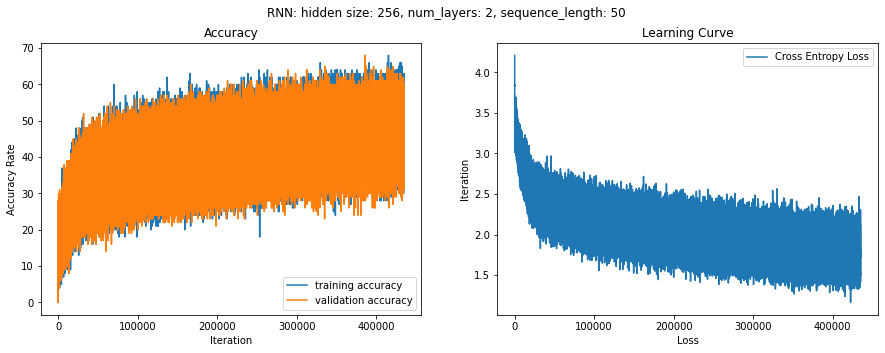

In [19]:
histogram = plt.figure()
histogram.set_size_inches(15, 5)
# training accuracy
plt.subplot(1,2,1)
plt.plot(training_acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Accuracy Rate")
plt.title("Accuracy")

# learning curve
plt.subplot(1,2,2)
plt.plot(learning_curve, label='Cross Entropy Loss')
plt.legend()
plt.xlabel("Loss")
plt.ylabel("Iteration")
plt.title("Learning Curve")

chart_title = 'RNN: hidden size: ' + str(hidden_size) + ', num_layers: ' + str(num_layers) + ', sequence_length: ' + str(sequence_length)
title = 'RNN.hidden_size.' + str(hidden_size) + '.num_layers.' + str(num_layers) + '.sequence_length.' + str(sequence_length)+".png"
histogram.suptitle(chart_title)
histogram.savefig(title)

In [20]:
def generator(model, sequences, idx_to_char, vocab_to_int, n_chars):
    text = ""
    # Set the model in evalulation mode
    #model.eval()

    softmax = nn.Softmax(dim=1)
    
    # select seed randomly from dataset
    #start = np.random.randint(0, len(sequences)-1)
    
    # use first entry as seed
    start = 0
    
    # The pattern is defined given the random idx
    pattern = sequences[start]
    
    # print using dictionaries to convert number to text
    
    # save to text file
    text += "\nPattern: \n"
    pat_text = ""
    for value in pattern:
        pat_text += idx_to_char[value]
    text += pat_text
    
    # print
    print("\nPattern: \n")
    print(''.join([idx_to_char[value] for value in pattern]), "\"")
    
    # In full_prediction we will save the complete prediction
    full_prediction = pattern.copy()
   
    # The prediction starts, it is going to be predicted a given
    # number of characters
    for i in range(n_chars):
        
        # The numpy patterns is transformed into a tesor-type and reshaped
        pattern_one_hot = one_hot_encode(np.array([pattern],dtype=int), num_classes)
        pattern_one_hot = torch.from_numpy(pattern_one_hot).type(torch.float).to(device)
        prediction = model(pattern_one_hot)
        prediction = softmax(prediction)
        prediction = prediction.squeeze().detach().cpu().numpy()
        arg_max = np.argmax(prediction)
        pattern = pattern[1:]
        pattern = np.append(pattern, arg_max)
        
        # The full prediction is saved
        full_prediction = np.append(full_prediction, arg_max)
    text += "\nPrediction: \n"
    pred_text = ""
    for value in full_prediction:
        pred_text += idx_to_char[value]
    text += pred_text
    print("Prediction: \n")
    print(''.join([idx_to_char[value] for value in full_prediction]), "\"")
    return text

In [21]:
text_generated = "Hidden size: " + str(hidden_size) +", sequence length: " +str(sequence_length) +"\n"
for epoch in range(num_epochs):
    model_rnn = RNN(sequence_length, hidden_size, num_layers, num_classes).to(device)
    PATH = 'rnn_' + str(epoch) + 'epochs.pt'
    model_rnn.load_state_dict(torch.load(PATH))
    model_rnn.eval()
    text_generated += "\nEpoch: " + str(epoch+1) + "\n"
    text_generated += generator(model_rnn, sequences, int_to_char, char_to_int, 2500) + "\n"


Pattern: 

d to be her knight!

HERMIA:

BOTTOM:
Are we all m "
Prediction: 

d to be her knight!

HERMIA:

BOTTOM:
Are we all me the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t

Prediction: 

d to be her knight!

HERMIA:

BOTTOM:
Are we all me the mand the sould the sear here
The sould be the with the sore and the hast the sear
That shall we the with the sourd the sear here
The sear he will and here the sore the will
The bear his and the will with the sear of the hare
That with the sould and the sour of the hard of the
sore the sould the prain the pray he will he will
I wall the will and the will with the sear of the
That with the wist the will with the sould the sand
The bear hat hear and the coust the sore,
And the kent of the will and the will sear
The sear he will with the sould be the will with
And the will with the will he will with here
The seall the will and the coust the sore,
The pare the sould the sear a dore the will
The will he will and the bear and the hast the
That with the sould be the with the sear and her
And the bear and be the sear and the singe,
The for the seall the will and the his doust
And the with the sould be the will with the sore
T

Prediction: 

d to be her knight!

HERMIA:

BOTTOM:
Are we all me the manter the serve the seed
That is the send the sure of the come that shall be
The seep the seave the sond and the serven and the
some to the seave the seave the parted for the ser
And the seep to the some to the sould be stare
The fare of the send the pray the such a sparter
That the sould be the seave the parter for the ser
And the seep to the some to the sould be stare
The fare of the send the pray the such a sparter
That the sould be the seave the parter for the ser
And the seep to the some to the sould be stare
The fare of the send the pray the such a sparter
That the sould be the seave the parter for the ser
And the seep to the some to the sould be stare
The fare of the send the pray the such a sparter
That the sould be the seave the parter for the ser
And the seep to the some to the sould be stare
The fare of the send the pray the such a sparter
That the sould be the seave the parter for the ser
And the seep to

In [22]:
# PATH = 'rnn_5epochs.pt'
# torch.save(rnn.state_dict(), PATH)
with open('text generationRNN.txt', 'w') as w:
    w.write(str(text_generated))

In [23]:
def generator_fixed(model, sequences, idx_to_char, vocab_to_int, n_chars):
    text = ""
    # Set the model in evalulation mode
    #model.eval()

    softmax = nn.Softmax(dim=1)
    
    seed = "CORDELIA:\nHad you not been their father, these whi"
    
    # print using dictionaries to convert number to text
    pattern = np.array([char_to_int[c] for c in seed], dtype=np.int32)
    
    # save to text file
    text += "\nPattern: \n"
    pat_text = ""
    for value in pattern:
        pat_text += idx_to_char[value]
    text += pat_text
    
    # print
    print("\nPattern: \n")
    print(''.join([idx_to_char[value] for value in pattern]), "\"")
    
    # In full_prediction we will save the complete prediction
    full_prediction = pattern.copy()
   
    # The prediction starts, it is going to be predicted a given
    # number of characters
    for i in range(n_chars):
        
        # The numpy patterns is transformed into a tesor-type and reshaped
        pattern_one_hot = one_hot_encode(np.array([pattern],dtype=int), num_classes)
        pattern_one_hot = torch.from_numpy(pattern_one_hot).type(torch.float).to(device)
        prediction = model(pattern_one_hot)
        prediction = softmax(prediction)
        
        prediction = prediction.squeeze().detach().cpu().numpy()
        arg_max = np.argmax(prediction)
        pattern = pattern[1:]
        pattern = np.append(pattern, arg_max)
        
        # The full prediction is saved
        full_prediction = np.append(full_prediction, arg_max)
    text += "\nPrediction: \n"
    pred_text = ""
    for value in full_prediction:
        pred_text += idx_to_char[value]
    text += pred_text
    print("Prediction: \n")
    print(''.join([idx_to_char[value] for value in full_prediction]), "\"")
    return text

In [27]:
text_generated = "Hidden size: " + str(hidden_size) +", sequence length: " +str(sequence_length) +"\n"
for epoch in range(num_epochs):
    model = RNN(sequence_length, hidden_size, num_layers, num_classes).to(device)
    PATH = 'rnn_' + str(epoch) + 'epochs.pt'
    model.load_state_dict(torch.load(PATH))
    model.eval()
    text_generated += "\nEpoch: " + str(epoch+1) + "\n"
    text_generated += generator_fixed(model, sequences, int_to_char, char_to_int, 2500) + "\n"


Pattern: 

CORDELIA:
Had you not been their father, these whi "
Prediction: 

CORDELIA:
Had you not been their father, these whin the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t

Prediction: 

CORDELIA:
Had you not been their father, these whith the sore
The sear hat here the sore the sore the sear
The sear has and the will and the here and here
The sear of the bear and the singe the sore
That she lowe the come to the will with the sore
That with the sould the will and the will so for
The will and the with a the for the fore.

BORINAN:
I wall the will a the the for the sould the sear
The sore the sear and the sear and the hare
The sour the seave the sould be the comest of the
That here the sould the sear and the coust of the
That with the sould the sould the serest the sear
The sear and the sould the sear and here and here
The sear and the come to the sore and the hare
The bear and the will with the sore of the here
The sear a dourd and the will and here the sear
The will he will and the will with the will he will
I wall the will with the sould the will he will
The will he will with the sear of the will her
And the will with the sear of the will and her
The bea

Prediction: 

CORDELIA:
Had you not been their father, these which a sond
That the some that the sould be the sear the store
the see the seave the sent and the seep to the store.

LARENTES:
I will the will the sould of the come to the store.

LARDINE:
I shall the king of the some that the suck of the
That the sould be she the sond of the sould
And the seep to the some to the some to the store
That the seeve the sear the seave the sear to the store
the seeve the seed to the store the send and the
That the seave the send a conder and the seep
That the seep to the some that the such of the come
That the seep the sould and the parten the sould
And the some to the some to the some to the store
That the seeve the sear the seave the sear to the store
the seeve the seed to the store the send and the
That the seave the send a conder and the seep
That the seep to the some that the such of the come
That the seep the sould and the parten the sould
And the some to the some to the some to the store


In [28]:
# PATH = 'lstm_5epochs.pt'
# torch.save(lstm.state_dict(), PATH)
with open('text generation_256h50seq_fixed_seed.txt', 'w') as w:
    w.write(str(text_generated))